In [1]:
%%capture
!pip install evidently feature_engine

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from feature_engine.creation import CyclicalFeatures
from sklearn import preprocessing
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
import pickle

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.titlesize'] = 14
sns.set_style('whitegrid')

# Load data

In [3]:
df = pd.read_csv("/content/TEST TASK (dataset).zip")
df['install_date'] = pd.to_datetime(df.install_date)

In [4]:
df.head()

,total_sessions_day0,total_sessions_day1,total_sessions_day3,total_sessions_day7,chapters_finished_day0,chapters_finished_day1,chapters_finished_day3,chapters_finished_day7,chapters_opened_day0,chapters_opened_day1,chapters_opened_day3,chapters_opened_day7,chapters_closed_day0,chapters_closed_day1,chapters_closed_day3,chapters_closed_day7,diamonds_received_day0,diamonds_received_day1,diamonds_received_day3,diamonds_received_day7,diamonds_spent_day0,diamonds_spent_day1,diamonds_spent_day3,diamonds_spent_day7,tickets_spent_day0,tickets_spent_day1,tickets_spent_day3,tickets_spent_day7,retained_day1,retained_day3,retained_day7,chapters_finished_session1,chapters_finished_session3,chapters_finished_session9,chapters_opened_session1,chapters_opened_session3,chapters_opened_session9,chapters_closed_session1,chapters_closed_session3,chapters_closed_session9,diamonds_spent_session1,diamonds_spent_session3,diamonds_spent_session9,tickets_spent_session1,tickets_spent_session3,tickets_spent_session9,app_sub_ltv_day0,app_sub_ltv_day1,app_sub_ltv_day3,app_iap_ltv_day0,app_iap_ltv_day1,app_iap_ltv_day3,media_source,install_date,country_code,ad_ltv_day0,ad_ltv_day1,ad_ltv_day3,platform,target_sub_ltv_day30,target_iap_ltv_day30,target_ad_ltv_day30,target_full_ltv_day30
0,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,SOURCE_23,2021-12-03,COUNTRY_135,0.0,0.0,0.0,ios,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,SOURCE_2,2021-12-03,COUNTRY_141,0.0,0.0,0.0,android,0.0,0.0,0.0,0.0
2,1.0,2.0,2.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,SOURCE_17,2021-12-03,COUNTRY_141,0.0,0.0,0.0,android,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,SOURCE_23,2021-12-03,COUNTRY_141,0.0,0.0,0.0,ios,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,SOURCE_1,2021-12-03,COUNTRY_203,0.0,0.0,0.0,android,0.0,0.0,0.0,0.0


In [5]:
df.shape

(1467832, 63)

In [6]:
TARGET_COL = ['target_sub_ltv_day30', 'target_iap_ltv_day30', 'target_ad_ltv_day30', 'target_full_ltv_day30']
CATEGORY_COL = ['media_source', 'country_code', 'platform']
DATE_COL = ['install_date']
NUM_COLS = [x for x in df if x not in CATEGORY_COL + DATE_COL + TARGET_COL]

# EDA

## Target

In [7]:
df[TARGET_COL].describe()

,target_sub_ltv_day30,target_iap_ltv_day30,target_ad_ltv_day30,target_full_ltv_day30
count,1.467832e+06,1.467832e+06,1.467832e+06,1.467832e+06
mean,2.203037e-02,2.139268e-01,2.091572e-02,2.568728e-01
std,3.088758e-01,2.097916e+00,1.601929e-01,2.274466e+00
min,-2.829604e+00,0.000000e+00,0.000000e+00,-2.777195e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,4.545741e+01,2.687878e+02,3.393084e+01,2.720042e+02


In [8]:
df[df["target_sub_ltv_day30"] < 0]

,total_sessions_day0,total_sessions_day1,total_sessions_day3,total_sessions_day7,chapters_finished_day0,chapters_finished_day1,chapters_finished_day3,chapters_finished_day7,chapters_opened_day0,chapters_opened_day1,chapters_opened_day3,chapters_opened_day7,chapters_closed_day0,chapters_closed_day1,chapters_closed_day3,chapters_closed_day7,diamonds_received_day0,diamonds_received_day1,diamonds_received_day3,diamonds_received_day7,diamonds_spent_day0,diamonds_spent_day1,diamonds_spent_day3,diamonds_spent_day7,tickets_spent_day0,tickets_spent_day1,tickets_spent_day3,tickets_spent_day7,retained_day1,retained_day3,retained_day7,chapters_finished_session1,chapters_finished_session3,chapters_finished_session9,chapters_opened_session1,chapters_opened_session3,chapters_opened_session9,chapters_closed_session1,chapters_closed_session3,chapters_closed_session9,diamonds_spent_session1,diamonds_spent_session3,diamonds_spent_session9,tickets_spent_session1,tickets_spent_session3,tickets_spent_session9,app_sub_ltv_day0,app_sub_ltv_day1,app_sub_ltv_day3,app_iap_ltv_day0,app_iap_ltv_day1,app_iap_ltv_day3,media_source,install_date,country_code,ad_ltv_day0,ad_ltv_day1,ad_ltv_day3,platform,target_sub_ltv_day30,target_iap_ltv_day30,target_ad_ltv_day30,target_full_ltv_day30
324112,1.0,1.0,1.0,1.0,7,7,7,7,11,11,11,11,6,6,6,6,48,48,48,48,17,17,17,17,3,3,3,3,0,0,0,9,9,9,13,13,13,9,9,9,89,107,107,3,3,3,0.0,-2.829604,-2.829604,0.00000,0.000000,0.000000,SOURCE_23,2022-01-28,COUNTRY_123,0.032012,0.032012,0.032012,ios,-2.829604,0.000000,0.052409,-2.777195
1026084,3.0,6.0,7.0,7.0,8,11,15,15,10,12,16,16,1,1,2,2,444,535,656,656,429,567,679,679,8,10,12,12,1,0,0,1,8,15,3,10,16,1,1,2,46,429,679,1,8,12,0.0,0.000000,-0.619771,6.33487,8.247829,9.071147,SOURCE_23,2022-01-03,COUNTRY_72,0.033082,0.063409,0.063409,ios,-0.619771,9.071147,0.063409,8.514784


Датасет містить незначну кількість аутлаєрів. Їх можна прибрати без втрати якості моделі

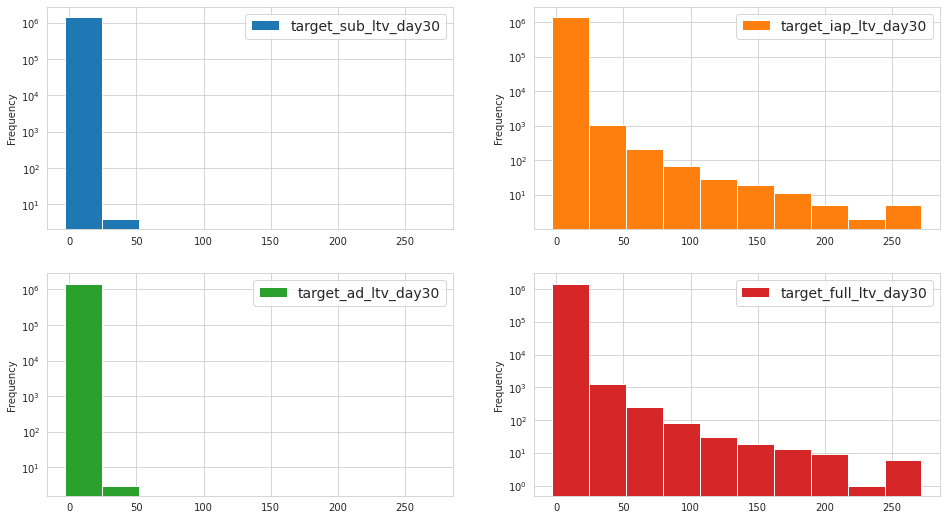

In [9]:
df[TARGET_COL].plot.hist(logy=True, subplots=True, layout=(2, 2), sharex=False, figsize=(16, 9));

- більша частина користувачів не приносить доходу взагалі
- ltv має розподіл у вигляді довгого хвоста
- sub та ad мають виражену верхню межу ltv, на відміну від iap, що, загалом, логічно

## Over time

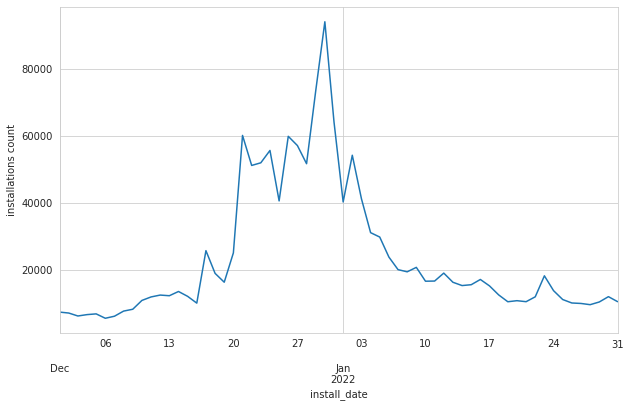

In [10]:
(
    df.groupby("install_date")
    .size()
    .plot(ylabel="installations count")
);

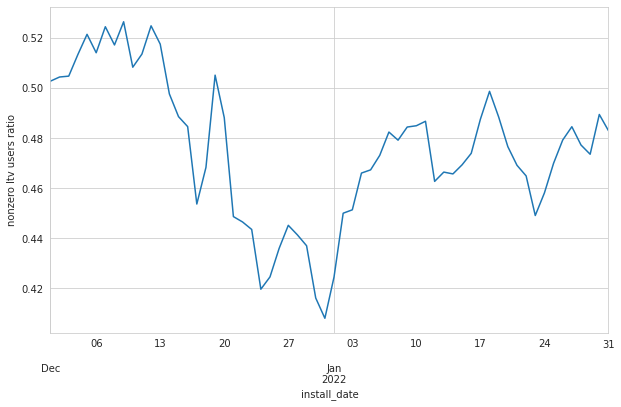

In [11]:
(
  df.groupby("install_date")
  .apply(lambda x: np.count_nonzero(x) / x.size)
  .plot(ylabel="nonzero ltv users ratio")
);

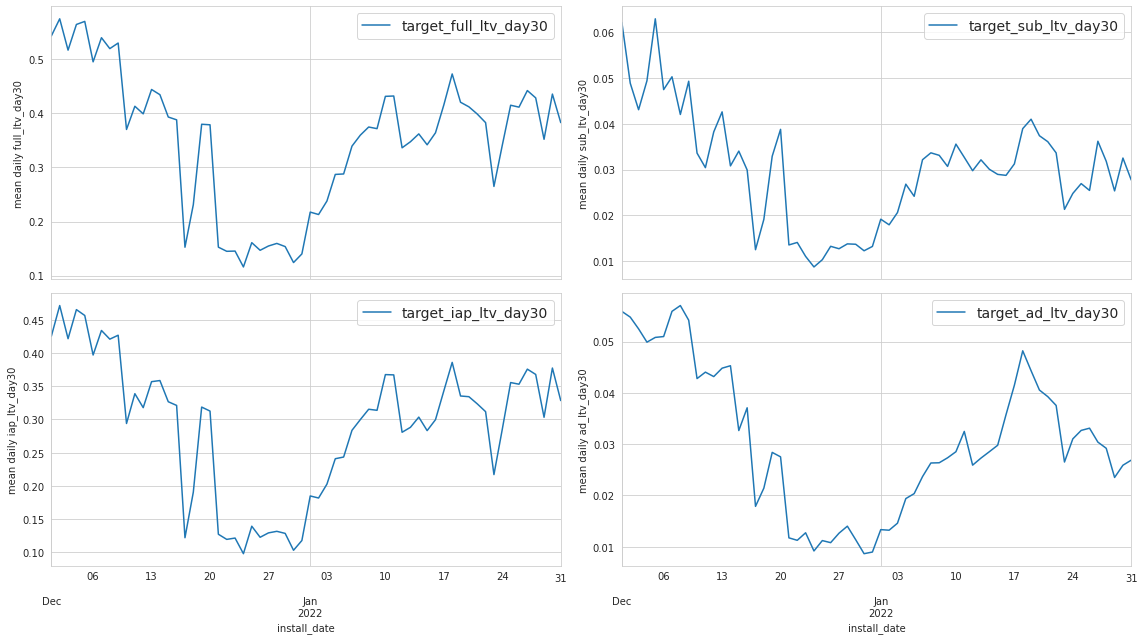

In [12]:
sorted_df = df.groupby("install_date").mean()

fig, axs = plt.subplots(2, 2, figsize=(16, 9), sharex=True)

sorted_df.ewm(com=0.1).mean().plot(y='target_full_ltv_day30', ax=axs[0, 0], ylabel="mean daily full_ltv_day30")
sorted_df.ewm(com=0.1).mean().plot(y='target_sub_ltv_day30', ax=axs[0, 1], ylabel="mean daily sub_ltv_day30")
sorted_df.ewm(com=0.1).mean().plot(y='target_iap_ltv_day30', ax=axs[1, 0], ylabel="mean daily iap_ltv_day30")
sorted_df.ewm(com=0.1).mean().plot(y='target_ad_ltv_day30', ax=axs[1, 1], ylabel="mean daily ad_ltv_day30")

plt.tight_layout()

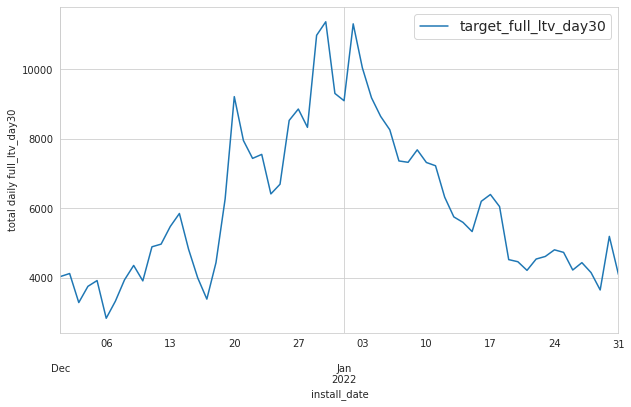

In [13]:
(
    df.groupby("install_date")
    .sum()
    .ewm(com=0.1)
    .mean()
    .plot(y='target_full_ltv_day30', ylabel="total daily full_ltv_day30")
);

Напередодні Нового року відбувається помітний наплив користувачів, при цьому новоприбула аудиторія не є якісною, що помітно по змінам розподілу середнього ltv на юзера, та частці юзерів з ненульовим ltv.
Сумарний ltv при цьому зростає

## Categorical

### "platform"

In [14]:
platform_data = df[['platform', 'target_sub_ltv_day30', 'target_iap_ltv_day30', 'target_ad_ltv_day30', 'target_full_ltv_day30']]

platform_data = platform_data.groupby(['platform']).agg(["mean", "sum"])
platform_data["count"] = df.platform.value_counts()
platform_data.T

platform                          android            ios
target_sub_ltv_day30  mean       0.007925       0.043596
                      sum     7033.283064   25303.603837
target_iap_ltv_day30  mean       0.082041       0.415577
                      sum    72805.257615  241203.277020
target_ad_ltv_day30   mean       0.009313       0.038656
                      sum     8264.586739   22436.180010
target_full_ltv_day30 mean       0.099279       0.497829
                      sum    88103.127418  288943.060867
count                       887426.000000  580406.000000

Робимо висновок, що в середньому користувачі ios "краща" аудиторія по усіх таргетах. Маємо бінарну ознаку з гарним потенціалом

### "media_source" & "country_code"


In [15]:
df.groupby("media_source")[TARGET_COL].mean().sort_values("target_full_ltv_day30", ascending=False)

,target_sub_ltv_day30,target_iap_ltv_day30,target_ad_ltv_day30,target_full_ltv_day30
media_source,,,,
SOURCE_5,0.076153,0.778048,0.073392,0.927592
SOURCE_3,0.061762,0.680612,0.065244,0.807617
SOURCE_21,0.007500,0.646436,0.019396,0.673333
SOURCE_18,0.059296,0.523441,0.034343,0.617079
SOURCE_8,0.000000,0.535177,0.073988,0.609165
SOURCE_16,0.045269,0.475273,0.043955,0.564497
SOURCE_17,0.047466,0.465405,0.046019,0.558890
SOURCE_14,0.050108,0.392887,0.042621,0.485616
SOURCE_1,0.039676,0.393268,0.052320,0.485264


In [16]:
df.groupby("country_code")[TARGET_COL].mean().sort_values("target_full_ltv_day30", ascending=False)

,target_sub_ltv_day30,target_iap_ltv_day30,target_ad_ltv_day30,target_full_ltv_day30
country_code,,,,
COUNTRY_96,0.114230,1.318636,0.034113,1.466979
COUNTRY_143,0.079872,0.969991,0.038438,1.088301
COUNTRY_168,0.063312,0.797491,0.059118,0.919921
COUNTRY_55,0.629530,0.114049,0.007666,0.751245
COUNTRY_65,0.011506,0.644979,0.056581,0.713066
...,...,...,...,...
COUNTRY_73,0.000000,0.000000,0.000000,0.000000
COUNTRY_48,0.000000,0.000000,0.000000,0.000000
COUNTRY_51,0.000000,0.000000,0.000000,0.000000


Очевидно, що розподіли користувачів з різних країн та різних джерел відрізняються, проте дані ознаки є анонімізованими, що сильно зменшує їх потенціал в feature engineering'у. Залишається включити їх в модель as is, та сподіватись, що модель підхопить залежності самостійно.